input from dummy excel

In [5]:
import pandas as pd

data = [
    ["2025-04-06 09:00:01", "Excel", "Key", "Ctrl+O", 200, 300, "Open dialog", "open_file"],
    ["2025-04-06 09:00:07", "Excel", "MouseClick", "Left", 215, 320, "File selected", "open_file"],
    ["2025-04-06 09:01:15", "Excel", "Key", "Ctrl+C", 420, 215, "Copy cell", "copy_data"],
    ["2025-04-06 09:01:20", "Excel", "Key", "Ctrl+V", 440, 220, "Paste cell", "copy_data"],
    ["2025-04-06 09:02:40", "Excel", "Key", "Alt+N", 310, 310, "Open Insert menu", "insert_chart"],
    ["2025-04-06 09:02:44", "Excel", "MouseClick", "Left", 320, 325, "Click 'Chart'", "insert_chart"],
    ["2025-04-06 09:04:00", "Excel", "Key", "Ctrl+S", 480, 240, "Save file", "save_file"],
    ["2025-04-06 09:04:20", "Excel", "Key", "Alt+F4", 500, 250, "Close app", "close_file"],
]

columns = ["Timestamp", "App", "Action Type", "Key/Button", "Cursor X", "Cursor Y", "Notes", "Intent"]
df = pd.DataFrame(data, columns=columns)


Preprocess

In [6]:
df['action_token'] = df['Action Type'] + ':' + df['Key/Button']

sequences = []
labels = []
window_size = 3
for i in range(len(df) - window_size + 1):
    seq = df['action_token'].iloc[i:i+window_size].tolist()
    label = df['Intent'].iloc[i+window_size-1]
    sequences.append(seq)
    labels.append(label)

training the model

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

X = [' '.join(seq) for seq in sequences]
y = labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', RandomForestClassifier(n_estimators=100, random_state=42))
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

   copy_data       0.00      0.00      0.00       2.0
insert_chart       0.00      0.00      0.00       0.0

    accuracy                           0.00       2.0
   macro avg       0.00      0.00      0.00       2.0
weighted avg       0.00      0.00      0.00       2.0



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

Predict

In [8]:
new_sequence = ["Key:Ctrl+C", "Key:Ctrl+V", "Key:Alt+N"]
sequence_input = ' '.join(new_sequence)
predicted_intent = pipeline.predict([sequence_input])[0]
print(f"Predicted Intent: {predicted_intent}")


Predicted Intent: insert_chart


Visualize sequences by predicted intent

<ipython-input-9-1846baa2e74d>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_pred, palette="viridis")


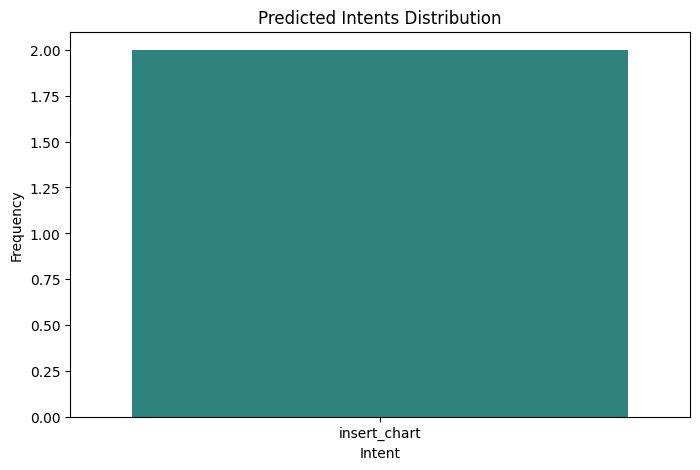

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
y_pred = pipeline.predict(X_test)
plt.figure(figsize=(8, 5))
sns.countplot(x=y_pred, palette="viridis")
plt.title("Predicted Intents Distribution")
plt.xlabel("Intent")
plt.ylabel("Frequency")
plt.show()


 Display confidence scores

In [10]:

new_sequence = ["Key:Ctrl+C", "Key:Ctrl+V", "Key:Alt+N"]
sequence_input = ' '.join(new_sequence)
probs = pipeline.predict_proba([sequence_input])[0]
classes = pipeline.named_steps['clf'].classes_
top_preds = sorted(zip(classes, probs), key=lambda x: x[1], reverse=True)[:3]
for intent, score in top_preds:
    print(f"{intent}: {score:.2f}")


insert_chart: 0.73
close_file: 0.19
save_file: 0.08


Create a feedback loop for active learning

In [11]:

predicted = pipeline.predict([sequence_input])[0]
print(f"Model Prediction: {predicted}")
feedback = input("Was this correct? (y/n): ")

if feedback.lower() == 'n':
    correct_intent = input("Please enter the correct intent: ")
    X_train.append(sequence_input)
    y_train.append(correct_intent)
    pipeline.fit(X_train, y_train)
    print("Model updated with new feedback.")


Model Prediction: insert_chart
Was this correct? (y/n): y
